In [46]:
from plotnine import *
import pandas as pd 
import numpy as np

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents

def toTfidf(text):
    vectorizer = TfidfVectorizer(stop_words = "english")
    # tokenize and build vocab
    return (vectorizer.fit_transform(text))

In [13]:
youtube_data = pd.read_csv("video_data_final.csv", encoding = "ISO-8859-1")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


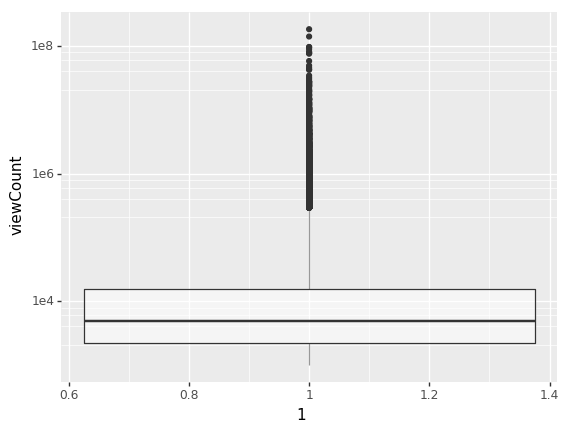

<ggplot: (-9223372036546187043)>

In [37]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

In [38]:
youtube_data["viewCount"].describe()

count    9.219100e+04
mean     6.946795e+04
std      1.248694e+06
min      0.000000e+00
25%      2.240000e+03
50%      4.942000e+03
75%      1.573100e+04
max      1.832004e+08
Name: viewCount, dtype: float64

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


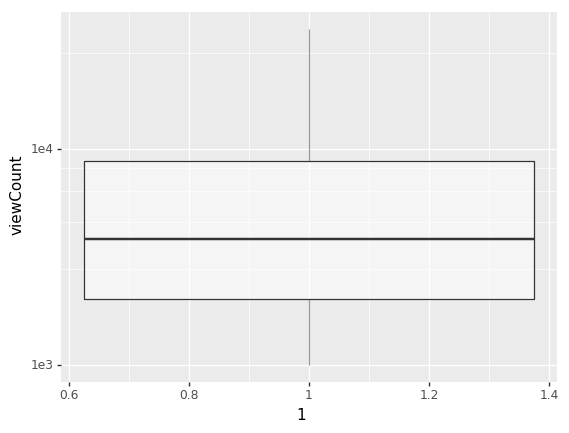

<ggplot: (-9223372036539741254)>

In [112]:
outlier_start = 1.5*(15731.00 - 2240.000) + 15731.00 #1.5(IQR) + 75th quartile
nonOutliers = youtube_data[youtube_data["viewCount"] <= outlier_start]
youtube_data['outlier'] = np.where(youtube_data['viewCount']>=outlier_start, 'outlier', 'notOutlier')
ggplot(df1, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + scale_y_log10()

In [47]:
allTitles = list(youtube_data['title'])
tfidf = toTfidf(allTitles)

  (0, 28358)	0.3285788985297511
  (0, 20542)	0.2991159733698071
  (0, 28161)	0.1716017991609054
  (0, 60392)	0.3469500842250931
  (0, 22930)	0.39591724042218573
  (0, 61235)	0.36509854950408227
  (0, 1921)	0.28103325634402354
  (0, 41952)	0.35169375576599
  (0, 42603)	0.4000355013837302
0.4000355013837302


In [48]:
def toFeatures(text):
    result = []
    for word in text.split():
        if (word in tfidf):
            result.append(tfidf[word])
        else:
            print(word)
    return result

In [49]:
def getFeatures(tfidf, tfidf_type):
    result = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i]
        if (tfidf_type == 'min'):
            result.append(np.min(vector))
        elif (tfidf_type == 'max'):
            result.append(np.max(vector))
        else:
            #average
            result.append(np.mean(vector))
    return pd.Series(result)

In [50]:
youtube_data['mean_title'] = getFeatures(tfidf, 'mean')

In [51]:
youtube_data['max_title'] = getFeatures(tfidf, 'max')

In [52]:
youtube_data['min_title'] = getFeatures(tfidf, 'min')

In [53]:
top_topics = ['Game', 'Vehicle', 'Video game', 'Concert', 'Car', 'Animation', 'Musician', 'Dance', 'Music video', 'Motorsport']

def numberCommon(topicsStr, top_topics):
    num = 0
    for word in top_topics:
        if word in topicsStr:
            num += 1
    return num
    

In [54]:
youtube_data['topics_features'] = youtube_data['topics'].apply(lambda topics : numberCommon(topics, top_topics))
youtube_data['game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Game' in topics else 0)
youtube_data['vehicle'] = youtube_data['topics'].apply(lambda topics : 1 if 'Vehicle' in topics else 0)
youtube_data['video_game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Video game' in topics else 0)
youtube_data['concert'] = youtube_data['topics'].apply(lambda topics : 1 if 'Concert' in topics else 0)
youtube_data['car'] = youtube_data['topics'].apply(lambda topics : 1 if 'Car' in topics else 0)

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


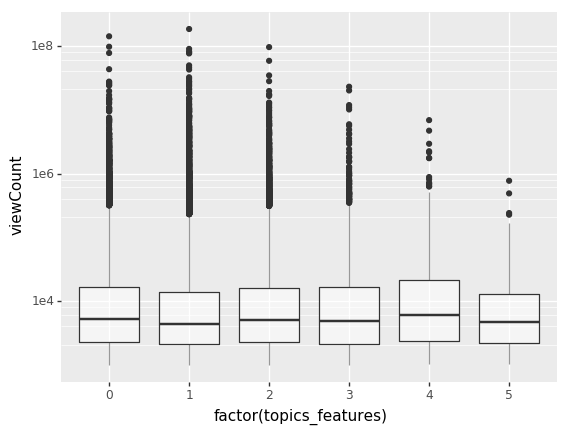

<ggplot: (293462392)>

In [55]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(topics_features)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


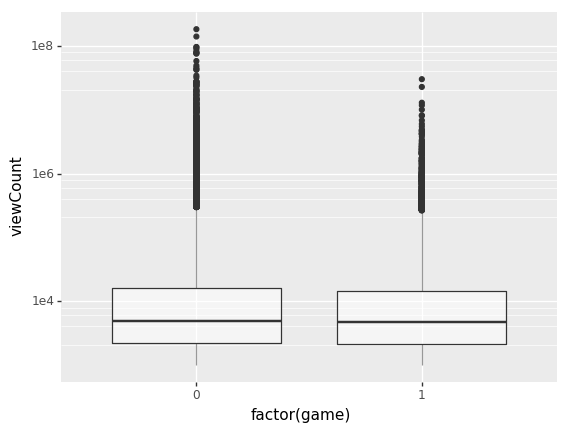

<ggplot: (-9223371953690839741)>

In [107]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(game)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


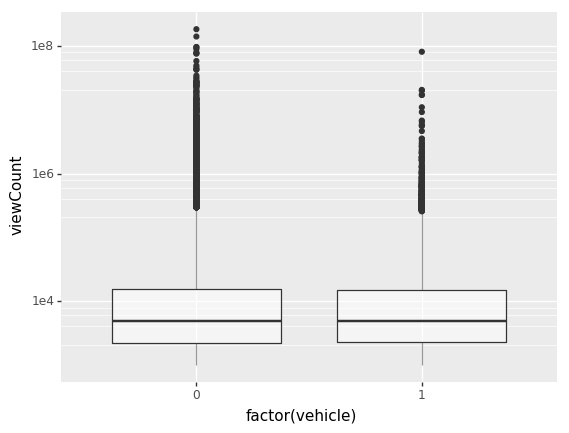

<ggplot: (-9223372036553882820)>

In [58]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(vehicle)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


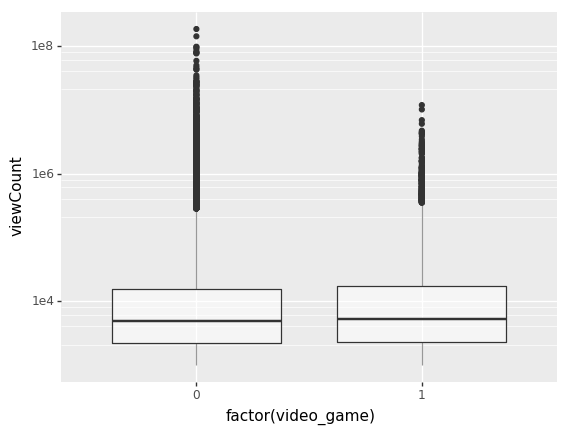

<ggplot: (83166307890)>

In [109]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(video_game)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


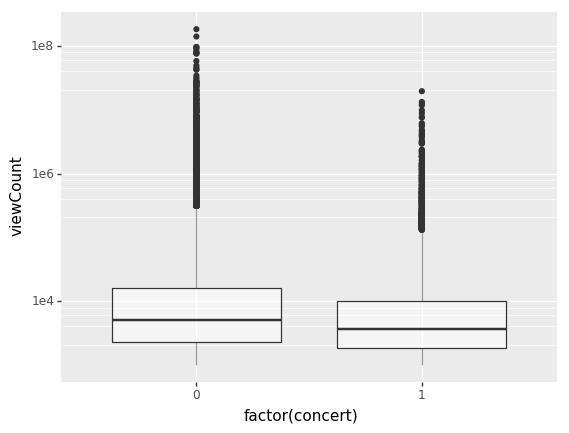

<ggplot: (-9223371953688424588)>

In [110]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(concert)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


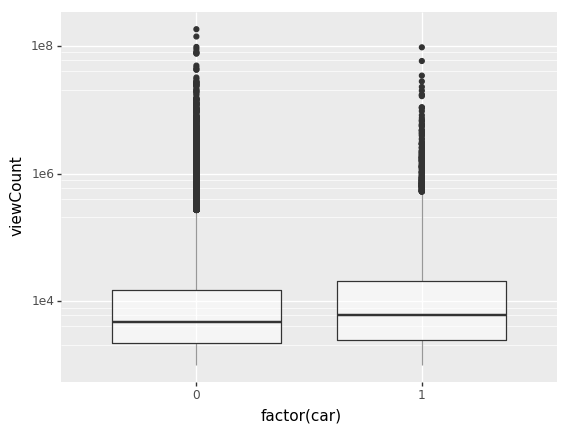

<ggplot: (83166199679)>

In [111]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(car)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


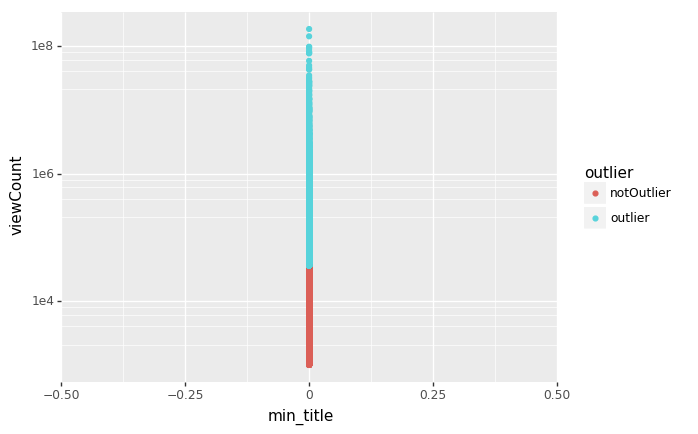

<ggplot: (-9223372036561510747)>

In [60]:
ggplot(youtube_data, aes(x = "min_title", y = "viewCount", color = "outlier")) + \
    geom_point() + \
    scale_y_log10()

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


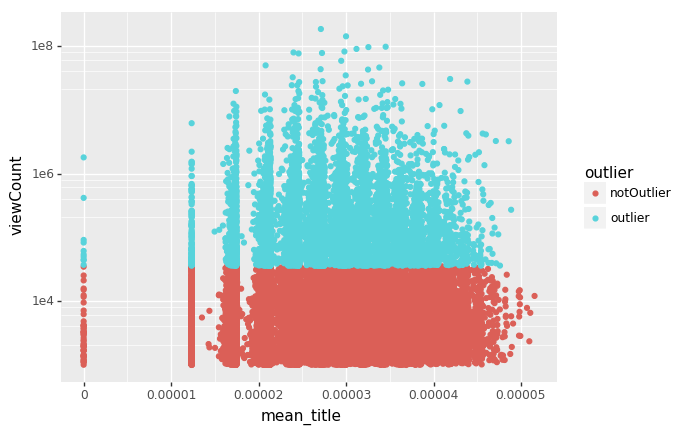

<ggplot: (-9223372036511355683)>

In [61]:
ggplot(youtube_data, aes(x = "mean_title", y = "viewCount", color = "outlier")) + \
    geom_point() + \
    scale_y_log10()

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


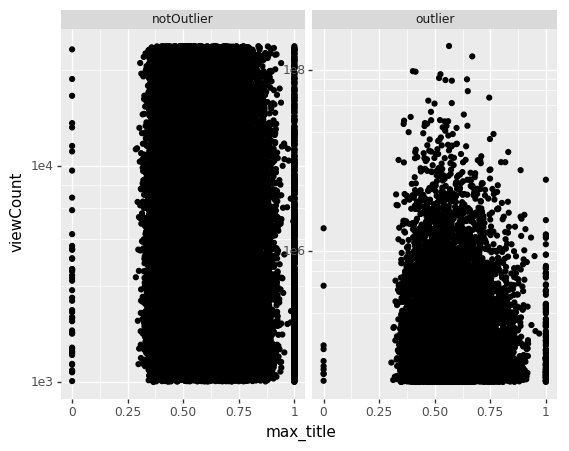

<ggplot: (-9223372036561510698)>

In [63]:
ggplot(youtube_data, aes(x = "max_title", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


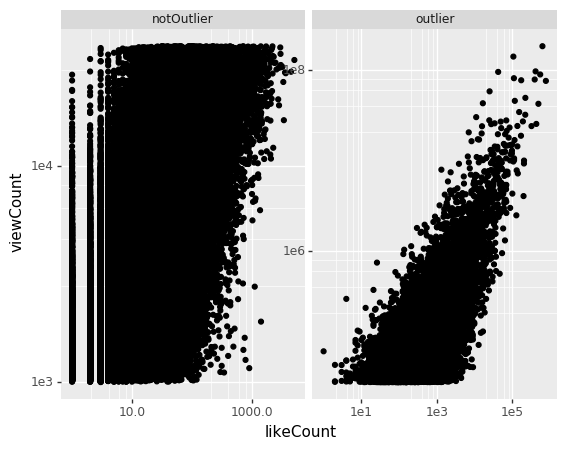

<ggplot: (-9223372036506316242)>

In [64]:
ggplot(youtube_data, aes(x = "likeCount", y = "viewCount",)) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10() + facet_wrap("outlier", scales="free")

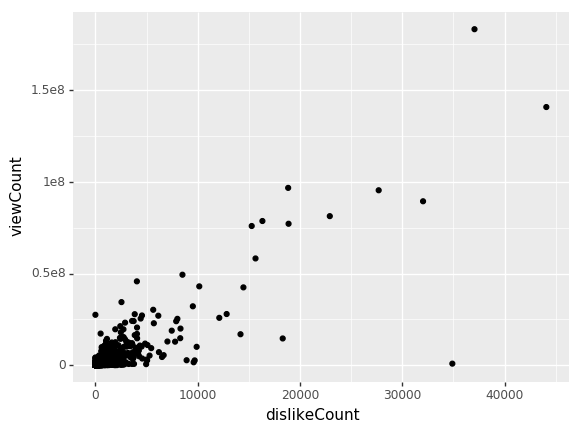

<ggplot: (83102807616)>

In [12]:
ggplot(youtube_data, aes(x = "dislikeCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10() 

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


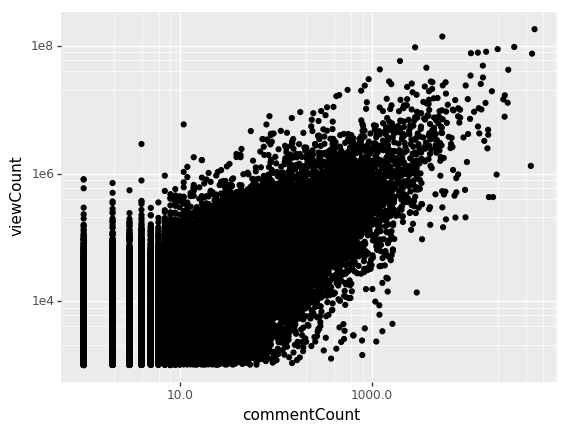

<ggplot: (-9223371953750141980)>

In [17]:
ggplot(youtube_data, aes(x = "commentCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10()

In [69]:
import nltk

youtube_data['pos_tags'] = youtube_data['title'].apply(lambda t: nltk.pos_tag(t))

In [70]:
print(youtube_data['pos_tags'])

0        [(L, NNP), (i, NN), (e, NN), (b, NN), (h, NN),...
1        [(R, NN), (i, NN), (t, VBP), (a, DT), ( , NN),...
2        [(S, NNP), (y, PRP), (l, VBP), (v, FW), (a, DT...
3        [(a, DT), (f, JJ), (t, NN), (e, NN), (r, NN), ...
4        [(S, NNP), (e, NN), (r, NN), (e, NN), (n, IN),...
5        [(E, NNP), (l, NN), (l, NN), (e, NN), (n, JJ),...
6        [(A, DT), (r, NN), (k, NN), (h, VBD), (a, DT),...
7        [(D, NNP), (r, VBZ), (a, DT), (w, NN), (i, NN)...
8        [(P, NNP), (H, NNP), (I, PRP), (L, NNP), ( , N...
9        [(S, NNP), (t, VBZ), (a, DT), (r, NN), ( , NN)...
10       [(C, NNP), (H, NNP), (A, NNP), (I, PRP), (R, N...
11       [(N, NNP), (e, NN), (e, NN), (d, NN), ( , NNP)...
12       [(M, NNP), (y, PRP), ( , NNP), (T, NNP), (a, D...
13       [(i, NN), (o, VBP), (n, NN), (i, NN), (k, VBP)...
14       [(S, NNP), (H, NNP), (I, PRP), (N, NNP), (e, V...
15       [(W, NNP), (H, NNP), (Y, NNP), ( , NNP), (I, P...
16       [(W, IN), (a, DT), (i, NN), (a, DT), (l, NN), .

In [71]:
from collections import Counter

youtube_data['pos_freq'] = youtube_data['pos_tags'].apply(lambda l: Counter([tag for (word, tag) in l]))

In [72]:
print(youtube_data['pos_freq'])

0        {'NNP': 9, 'NN': 31, 'VBD': 1, 'CD': 2, 'SYM':...
1        {'NN': 17, 'VBP': 4, 'DT': 2, 'NNP': 14, 'VBZ'...
2        {'NNP': 6, 'PRP': 1, 'VBP': 1, 'FW': 1, 'DT': ...
3         {'DT': 3, 'JJ': 1, 'NN': 12, 'VBZ': 2, 'NNP': 1}
4        {'NNP': 22, 'NN': 24, 'IN': 2, 'DT': 7, 'MD': ...
5        {'NNP': 15, 'NN': 9, 'JJ': 2, 'VBZ': 2, 'DT': ...
6        {'DT': 2, 'NN': 6, 'VBD': 1, 'NNP': 2, 'MD': 1...
7        {'NNP': 14, 'VBZ': 1, 'DT': 1, 'NN': 21, 'VBP'...
8        {'NNP': 37, 'PRP': 3, 'NN': 19, 'VBP': 3, 'JJ'...
9        {'NNP': 10, 'VBZ': 2, 'DT': 3, 'NN': 13, 'PRP'...
10       {'NNP': 17, 'PRP': 1, ':': 1, 'NN': 6, 'DT': 1...
11       {'NNP': 14, 'NN': 26, 'MD': 2, 'VB': 2, ':': 2...
12       {'NNP': 19, 'PRP': 1, 'DT': 3, 'NN': 21, 'JJ':...
13       {'NN': 30, 'VBP': 2, 'JJ': 2, 'NNP': 6, 'VBZ':...
14       {'NNP': 12, 'PRP': 2, 'VBD': 1, 'JJ': 1, ':': ...
15       {'NNP': 34, 'PRP': 2, 'VBP': 1, 'JJ': 1, 'NN':...
16       {'IN': 2, 'DT': 3, 'NN': 15, 'VBZ': 1, 'NNP': .

In [73]:
youtube_data['title_CC'] = youtube_data['pos_freq'].apply(lambda C: C['CC'])
youtube_data['title_CD'] = youtube_data['pos_freq'].apply(lambda C: C['CD'])
youtube_data['title_DT'] = youtube_data['pos_freq'].apply(lambda C: C['DT'])
youtube_data['title_EX'] = youtube_data['pos_freq'].apply(lambda C: C['EX'])
youtube_data['title_IN'] = youtube_data['pos_freq'].apply(lambda C: C['IN'])
youtube_data['title_JJ'] = youtube_data['pos_freq'].apply(lambda C: C['JJ'])
youtube_data['title_JJR'] = youtube_data['pos_freq'].apply(lambda C: C['JJR'])
youtube_data['title_JJS'] = youtube_data['pos_freq'].apply(lambda C: C['JJS'])
youtube_data['title_LS'] = youtube_data['pos_freq'].apply(lambda C: C['LS'])
youtube_data['title_MD'] = youtube_data['pos_freq'].apply(lambda C: C['MD'])
youtube_data['title_NN'] = youtube_data['pos_freq'].apply(lambda C: C['NN'])
youtube_data['title_NNP'] = youtube_data['pos_freq'].apply(lambda C: C['NNP'])
youtube_data['title_NNS'] = youtube_data['pos_freq'].apply(lambda C: C['NNS'])
youtube_data['title_PDT'] = youtube_data['pos_freq'].apply(lambda C: C['PDT'])
youtube_data['title_POS'] = youtube_data['pos_freq'].apply(lambda C: C['POS'])
youtube_data['title_PRP'] = youtube_data['pos_freq'].apply(lambda C: C['PRP'])
youtube_data['title_PRP$'] = youtube_data['pos_freq'].apply(lambda C: C['PRP$'])
youtube_data['title_RB'] = youtube_data['pos_freq'].apply(lambda C: C['RB'])
youtube_data['title_RBR'] = youtube_data['pos_freq'].apply(lambda C: C['RBR'])
youtube_data['title_RBS'] = youtube_data['pos_freq'].apply(lambda C: C['RBS'])
youtube_data['title_RP'] = youtube_data['pos_freq'].apply(lambda C: C['RP'])
youtube_data['title_TO'] = youtube_data['pos_freq'].apply(lambda C: C['TO'])
youtube_data['title_UH'] = youtube_data['pos_freq'].apply(lambda C: C['UH'])
youtube_data['title_VB'] = youtube_data['pos_freq'].apply(lambda C: C['VB'])
youtube_data['title_VBD'] = youtube_data['pos_freq'].apply(lambda C: C['VBD'])
youtube_data['title_VBG'] = youtube_data['pos_freq'].apply(lambda C: C['VBG'])
youtube_data['title_VBN'] = youtube_data['pos_freq'].apply(lambda C: C['VBN'])
youtube_data['title_VBP'] = youtube_data['pos_freq'].apply(lambda C: C['VBP'])
youtube_data['title_VBZ'] = youtube_data['pos_freq'].apply(lambda C: C['VBZ'])
youtube_data['title_WDT'] = youtube_data['pos_freq'].apply(lambda C: C['WDT'])
youtube_data['title_WP'] = youtube_data['pos_freq'].apply(lambda C: C['WP'])
youtube_data['title_WRB'] = youtube_data['pos_freq'].apply(lambda C: C['WRB'])

In [74]:
print(youtube_data['title_CC'].max(), youtube_data['title_CD'].max(), youtube_data['title_DT'].max(), youtube_data['title_EX'].max(),
     youtube_data['title_IN'].max(), youtube_data['title_JJ'].max(), youtube_data['title_JJR'].max(), youtube_data['title_JJS'].max(),
     youtube_data['title_LS'].max(), youtube_data['title_MD'].max(), youtube_data['title_NN'].max(), youtube_data['title_NNP'].max(),
     youtube_data['title_NNS'].max(), youtube_data['title_PDT'].max(), youtube_data['title_POS'].max(), youtube_data['title_PRP'].max(),
     youtube_data['title_PRP$'].max(), youtube_data['title_RB'].max(), youtube_data['title_RBR'].max(), youtube_data['title_RBS'].max(),
     youtube_data['title_RP'].max(), youtube_data['title_TO'].max(), youtube_data['title_UH'].max(), youtube_data['title_VB'].max(),
     youtube_data['title_VBD'].max(), youtube_data['title_VBG'].max(), youtube_data['title_VBN'].max(), youtube_data['title_VBP'].max(),
     youtube_data['title_VBZ'].max(), youtube_data['title_WDT'].max(), youtube_data['title_WP'].max(), youtube_data['title_WRB'].max())

4 36 17 0 6 17 1 0 1 7 67 197 5 2 7 12 1 6 1 0 2 1 1 8 16 2 0 14 10 0 4 2


In [126]:
posCols = [col for col in youtube_data.columns if 'title_' in col]
#allOutliers = youtube_data[youtube_data["viewCount"] >= outlier_start]
for colName in posCols:
    if (abs(nonOutliers['viewCount'].corr(nonOutliers[colName])) > 0.1):
        print("YAYYYYYYYYYYYY!")
    print(nonOutliers['viewCount'].corr(nonOutliers[colName]), youtube_data['viewCount'].corr(youtube_data[colName]))

0.008161545262232194 0.005375612455216976
-0.027186322815240263 -0.017991607150030262
0.024132394206406685 0.004564227947798553
nan nan
0.012543016305643234 0.0019410302833748282
0.033715557424776416 0.008055972875955221
0.0023753522846308626 -0.00021983570992459997
nan nan
-0.004346672200795796 -0.0011011241134624347
0.030461958999656216 0.003168994633730546
0.04088186717862512 0.006811004961611909
0.04422795737558795 0.011609950441739833
0.01375330470660473 0.0034761146729658
0.007346456324676465 0.0028752984160671613
0.005313864647648158 0.004629374680230809
0.0171678253513706 0.0031621129301697
-0.005516511840549344 0.00040671781185740207
0.013939978275664778 0.015664987134193013
-0.002961237742867709 -0.0002493744503023904
nan nan
-3.4703034096519624e-05 -0.0008223508705416981
nan -5.1361304672503384e-05
0.008601451075351723 -0.00011073994380819606
0.026243663422471572 0.006355117103333521
0.0058902061283168765 -0.0036668577840479073
0.0006183986374548301 0.0001628657553339609
nan

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


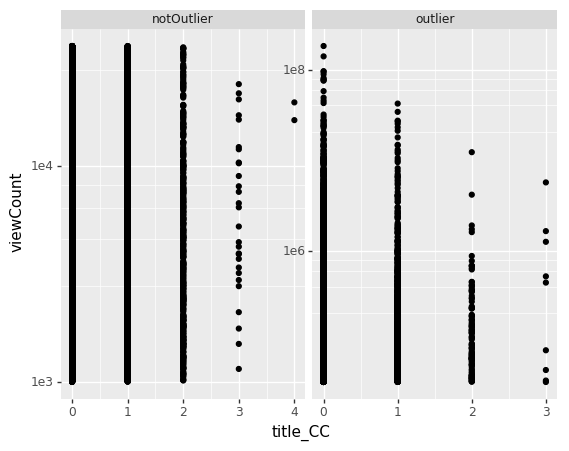

<ggplot: (349200013)>

In [75]:
ggplot(youtube_data, aes(x = "title_CC", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


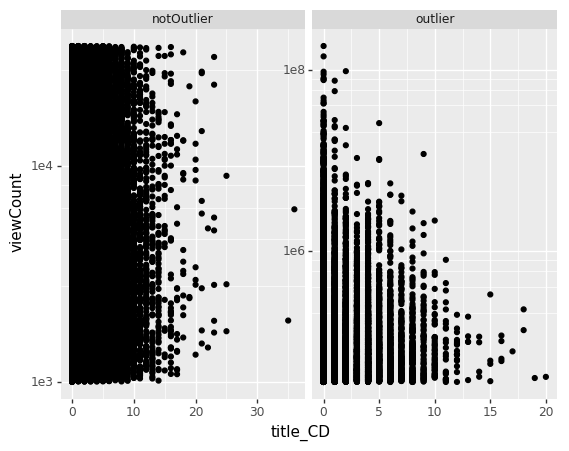

<ggplot: (-9223372036534925182)>

In [78]:
ggplot(youtube_data, aes(x = "title_CD", y = "viewCount")) + \
    geom_point()  + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


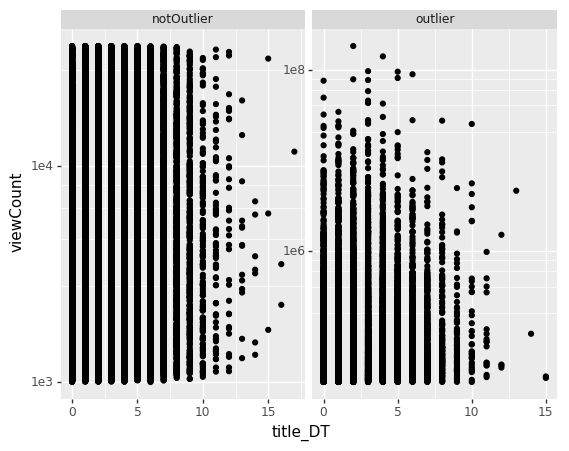

<ggplot: (-9223372036512065287)>

In [79]:
ggplot(youtube_data, aes(x = "title_DT", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

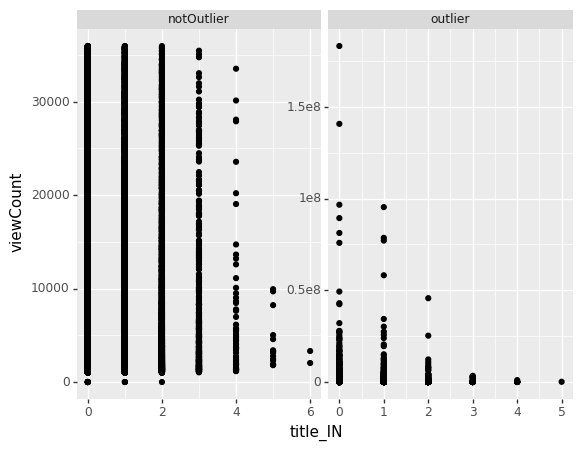

<ggplot: (-9223372036562657718)>

In [81]:
ggplot(youtube_data, aes(x = "title_IN", y = "viewCount")) + \
    geom_point() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


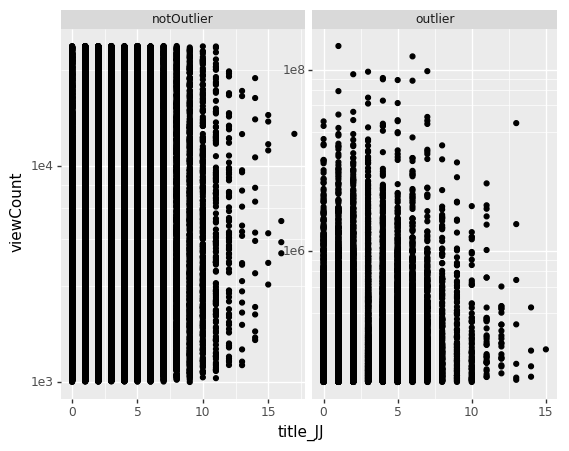

<ggplot: (-9223372036497434887)>

In [84]:
ggplot(youtube_data, aes(x = "title_JJ", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


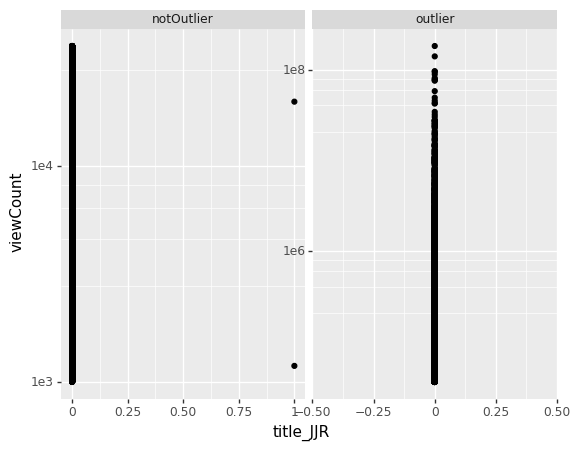

<ggplot: (319250289)>

In [85]:
ggplot(youtube_data, aes(x = "title_JJR", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


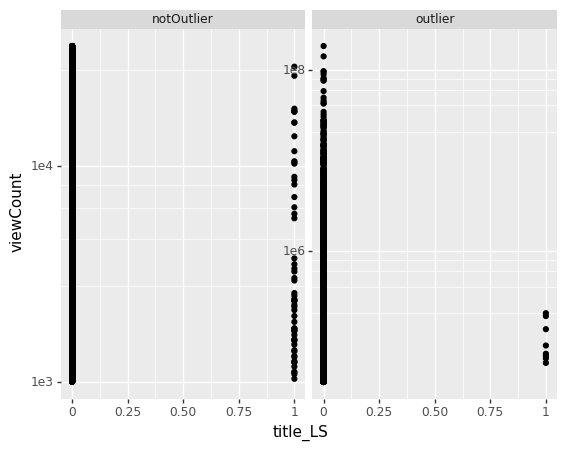

<ggplot: (-9223372036531402201)>

In [86]:
ggplot(youtube_data, aes(x = "title_LS", y = "viewCount")) + \
    geom_point()+ \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


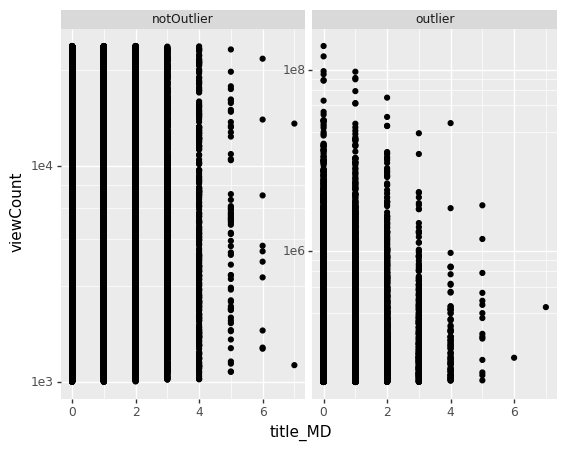

<ggplot: (360590684)>

In [87]:
ggplot(youtube_data, aes(x = "title_MD", y = "viewCount")) + \
    geom_point()+ \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


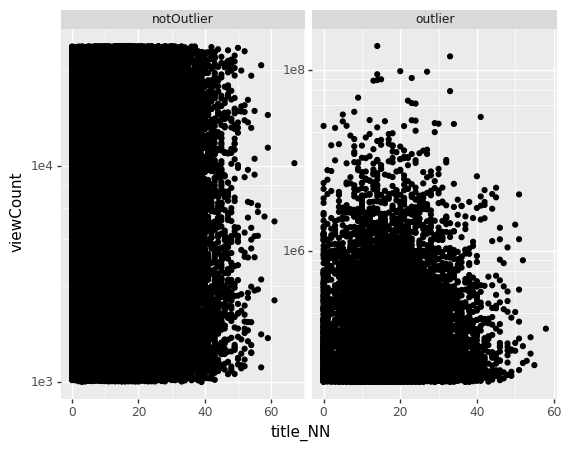

<ggplot: (368079231)>

In [88]:
ggplot(youtube_data, aes(x = "title_NN", y = "viewCount")) + \
    geom_point()+ \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


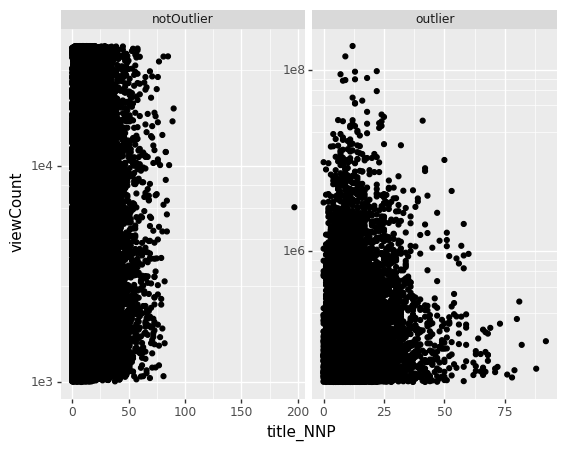

<ggplot: (-9223372036481561102)>

In [91]:
ggplot(youtube_data, aes(x = "title_NNP", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


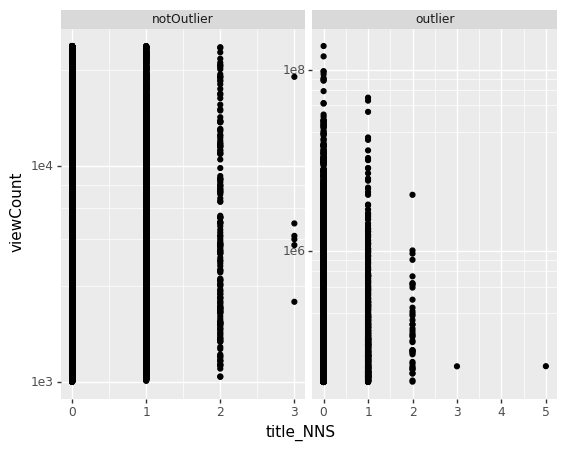

<ggplot: (386841671)>

In [92]:
ggplot(youtube_data, aes(x = "title_NNS", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


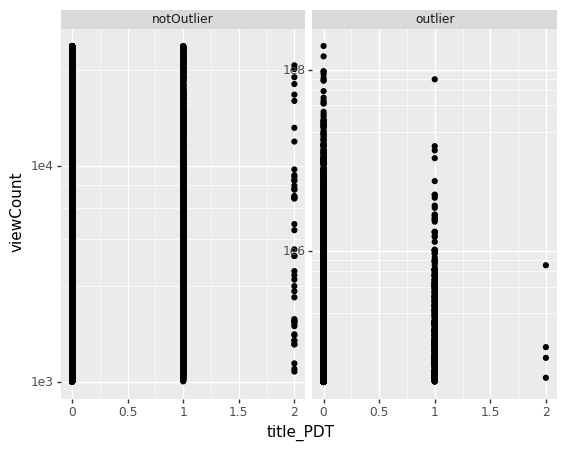

<ggplot: (391576054)>

In [93]:
ggplot(youtube_data, aes(x = "title_PDT", y = "viewCount")) + \
    geom_point()+ \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


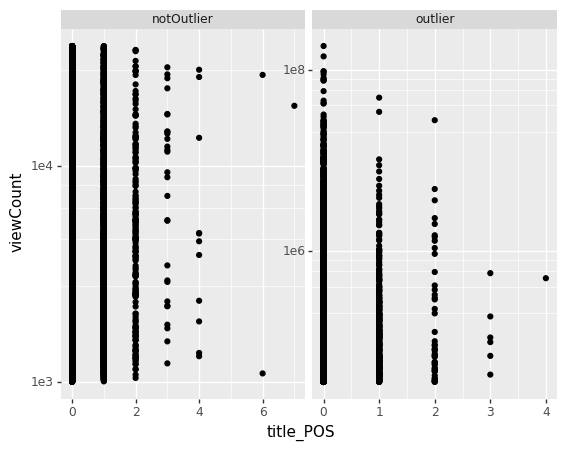

<ggplot: (377063670)>

In [94]:
ggplot(youtube_data, aes(x = "title_POS", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


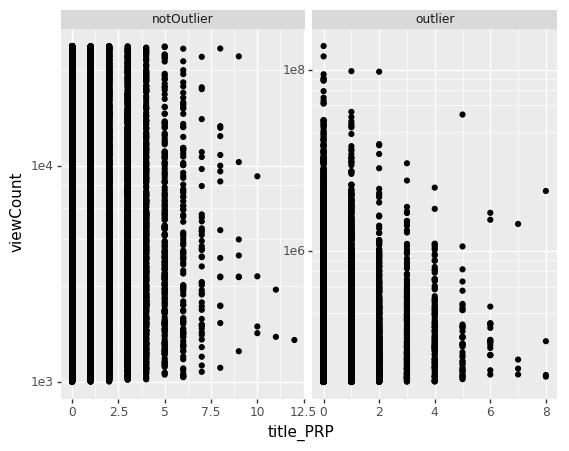

<ggplot: (-9223372036458819107)>

In [95]:
ggplot(youtube_data, aes(x = "title_PRP", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


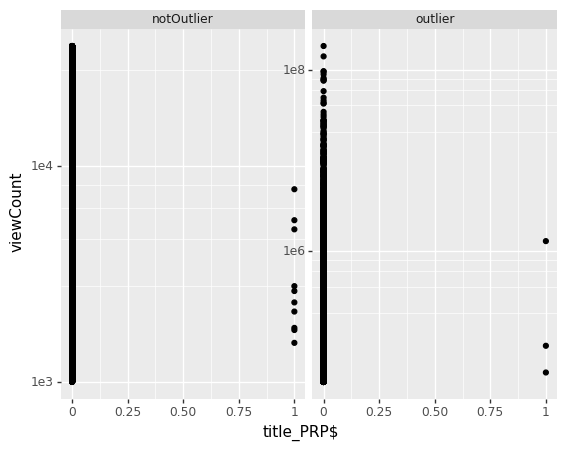

<ggplot: (406045213)>

In [96]:
ggplot(youtube_data, aes(x = "title_PRP$", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


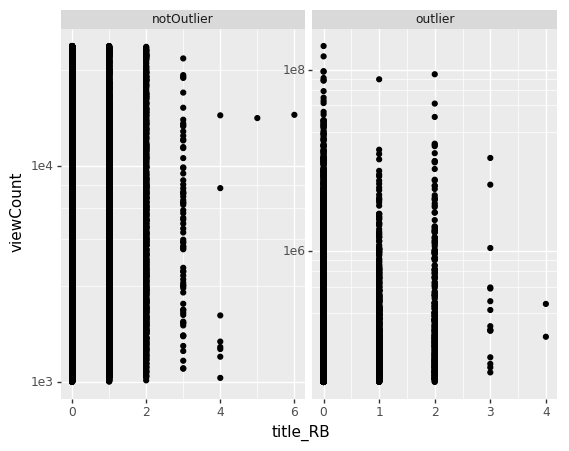

<ggplot: (-9223372036477308875)>

In [97]:
ggplot(youtube_data, aes(x = "title_RB", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


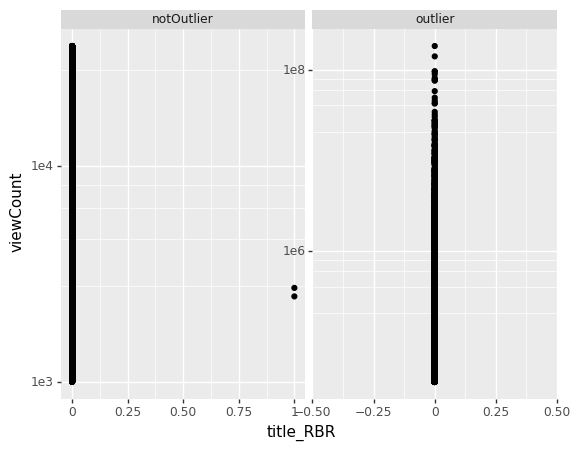

<ggplot: (-9223372036511675858)>

In [98]:
ggplot(youtube_data, aes(x = "title_RBR", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


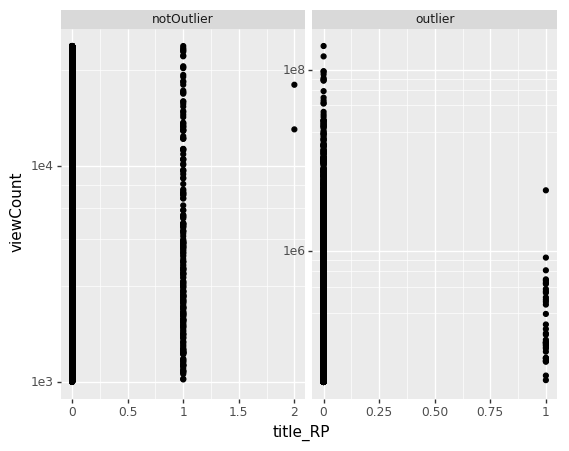

<ggplot: (-9223372036511725799)>

In [99]:
ggplot(youtube_data, aes(x = "title_RP", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


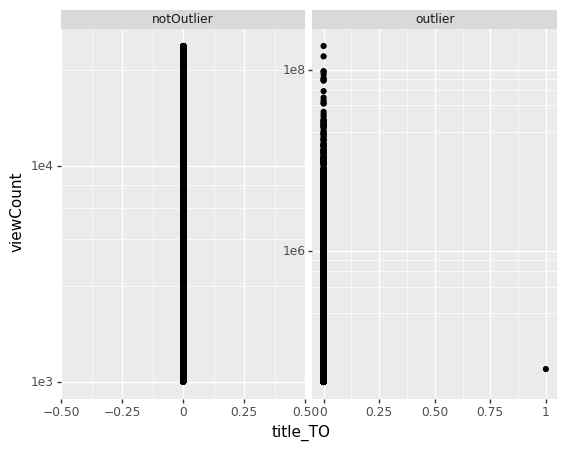

<ggplot: (-9223372036534929720)>

In [100]:
ggplot(youtube_data, aes(x = "title_TO", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


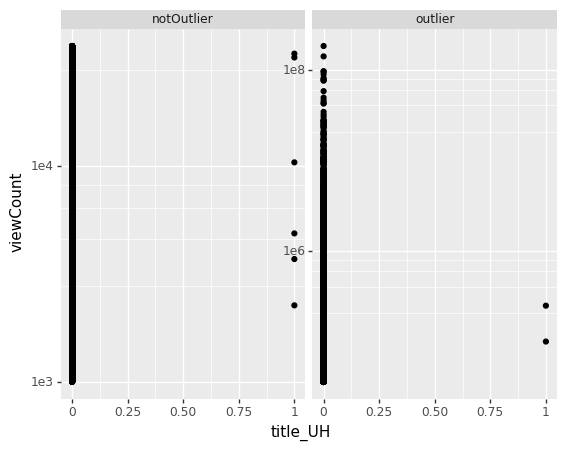

<ggplot: (349199992)>

In [101]:
ggplot(youtube_data, aes(x = "title_UH", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


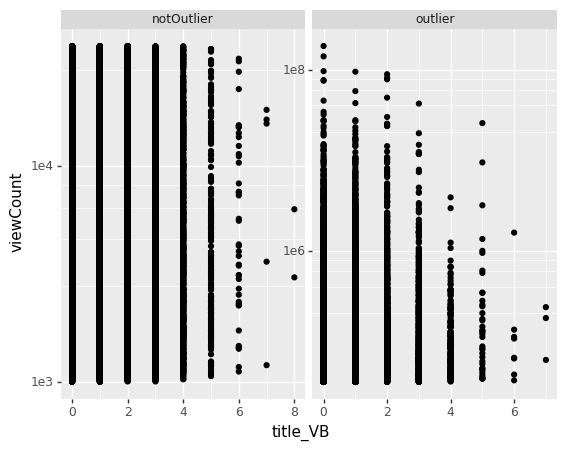

<ggplot: (-9223372036442425172)>

In [102]:
ggplot(youtube_data, aes(x = "title_VB", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

In [113]:
nonOutliers['title_VB'].corr(nonOutliers['viewCount'])

0.02624366342247157

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


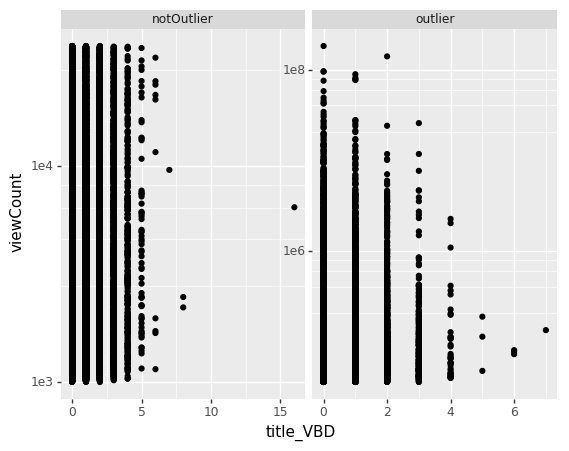

<ggplot: (-9223372036503746167)>

In [103]:
ggplot(youtube_data, aes(x = "title_VBD", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


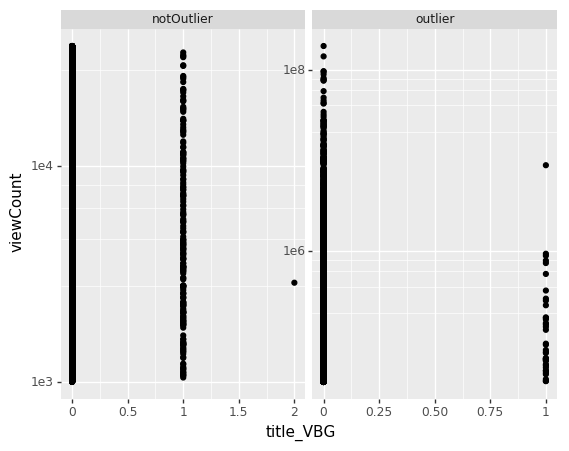

<ggplot: (366104275)>

In [104]:
ggplot(youtube_data, aes(x = "title_VBG", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


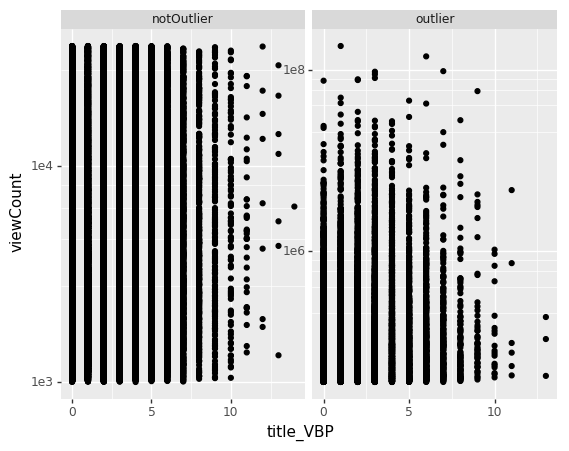

<ggplot: (-9223372036485826542)>

In [105]:
ggplot(youtube_data, aes(x = "title_VBP", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


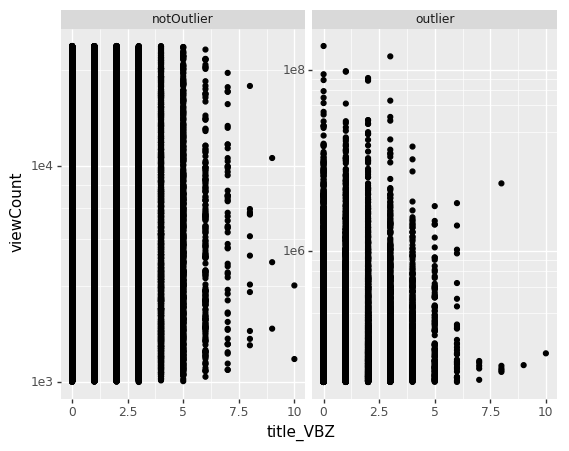

<ggplot: (-9223372036483369584)>

In [106]:
ggplot(youtube_data, aes(x = "title_VBZ", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


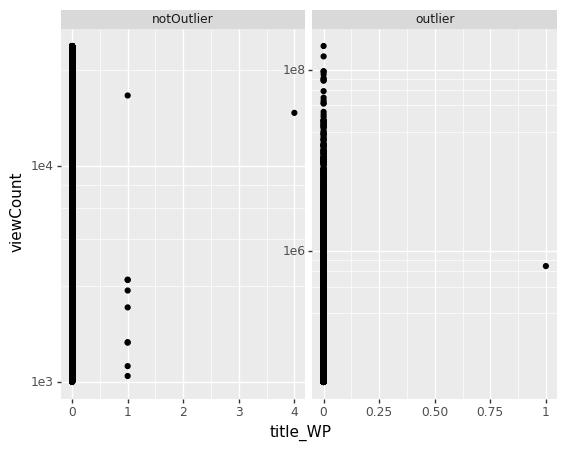

<ggplot: (-9223372036453138835)>

In [107]:
ggplot(youtube_data, aes(x = "title_WP", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


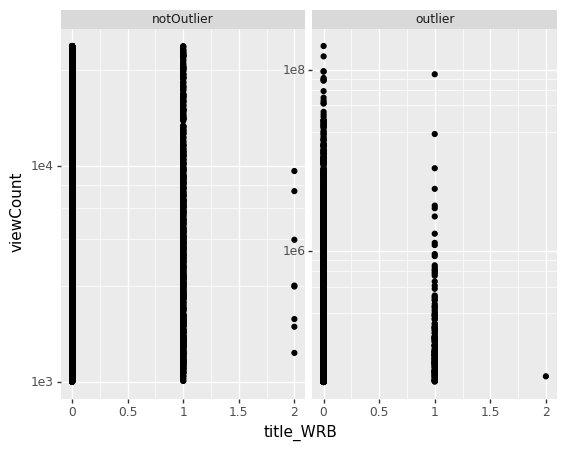

<ggplot: (419574718)>

In [108]:
ggplot(youtube_data, aes(x = "title_WRB", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

In [109]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getSentimentScore(text, sentimentType):
    #sentimentType: compound, neg, neu, pos
    return (analyzer.polarity_scores(text)[sentimentType])

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [110]:
youtube_data['description'] = youtube_data['description'].fillna('')

In [111]:
youtube_data['titlePos'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'pos'))
youtube_data['titleNeg'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neg'))
youtube_data['titleNeu'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neu'))
youtube_data['titleCompound'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'compound'))

In [ ]:
youtube_data['descriptionPos'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'pos'))
youtube_data['descriptionNeg'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'neg'))
youtube_data['descriptionNeu'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'neu'))
youtube_data['descriptionCompound'] = youtube_data['description'].apply(lambda text : getSentimentScore(text, 'compound'))

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


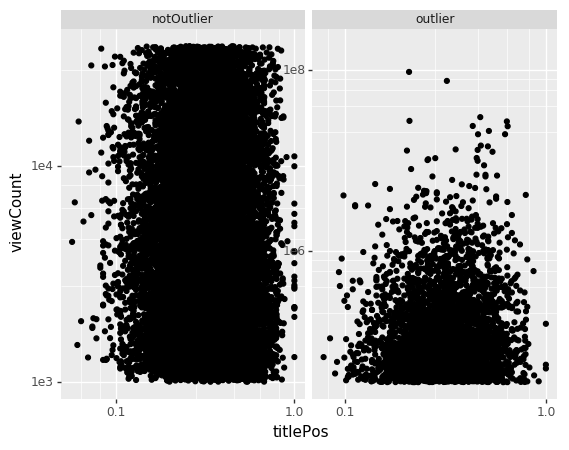

<ggplot: (-9223372036539969227)>

In [127]:
ggplot(youtube_data, aes(x = "titlePos", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


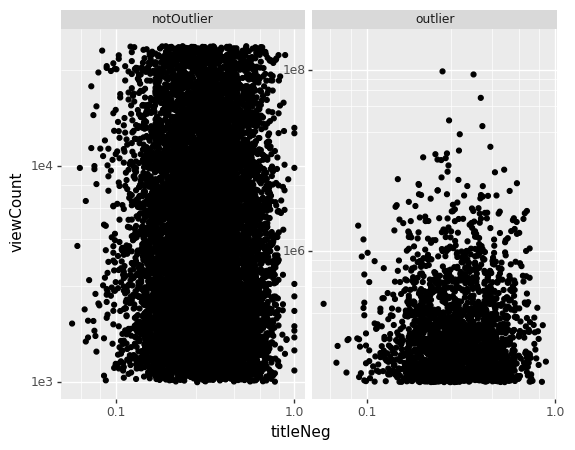

<ggplot: (431174050)>

In [128]:
ggplot(youtube_data, aes(x = "titleNeg", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

In [133]:
ggplot(youtube_data, aes(x = "titleNeu", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

#youtube_data['titleNeu'].corr(youtube_data['viewCount'])
#nonOutliers['titleNeu'].corr(nonOutliers['viewCount'])

-0.005328601531036772

In [ ]:
ggplot(youtube_data, aes(x = "titleCompound", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

In [ ]:
ggplot(youtube_data, aes(x = "descriptionPos", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionNeg", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionNeu", y = "viewCount")) + \
    geom_point()

In [ ]:
ggplot(youtube_data, aes(x = "descriptionCompound", y = "viewCount")) + \
    geom_point()